# Reddit Data Pre-Processing

In [1]:
import json
import os
import sys
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import nltk
from nltk import sent_tokenize, word_tokenize
%matplotlib inline  
pd.options.display.max_colwidth = 500

### Enter All Directory Info In Cell Below

My directory structure (Brandon):
```
reddit_data
    raw_data
        2007
        ...
        2015
    processed_data
        2007
        ...
        2015
```
Only info that needs to be changed to run this notebook is in the cell below.

In [2]:
print("You are currently in", os.getcwd(), "\n")
DATA_ROOT = '/home/brandon/terabyte/Datasets/reddit_data'
DATA_YEAR = '2007'
# Use os.path.join; it will figure out the '/' in between.
RAW_DATA_FILES = os.listdir(os.path.join(DATA_ROOT, 'raw_data', DATA_YEAR))
# Always work with full pathnames to be safe.
RAW_DATA_FILES = [os.path.join(DATA_ROOT, 'raw_data', DATA_YEAR, file) for file in RAW_DATA_FILES]
pprint(RAW_DATA_FILES)

You are currently in /home/brandon/Documents/seq2seq_projects/notebooks 

['/home/brandon/terabyte/Datasets/reddit_data/raw_data/2007/RC_2007-10',
 '/home/brandon/terabyte/Datasets/reddit_data/raw_data/2007/RC_2007-11',
 '/home/brandon/terabyte/Datasets/reddit_data/raw_data/2007/RC_2007-12']


## Load Data and Display Basic Info

In [3]:
df = pd.read_json(RAW_DATA_FILES[0], lines=True)
init_num_rows = len(df)
print("Number of lines in raw data file", init_num_rows)
pprint("Column names from raw data file:")
pprint(df.columns, width=100)

Number of lines in raw data file 150429
'Column names from raw data file:'
Index(['archived', 'author', 'author_flair_css_class', 'author_flair_text',
       'body', 'controversiality', 'created_utc', 'distinguished', 'downs',
       'edited', 'gilded', 'id', 'link_id', 'name', 'parent_id',
       'retrieved_on', 'score', 'score_hidden', 'subreddit', 'subreddit_id',
       'ups'],
      dtype='object')


In [4]:
def show_len_update(df):
    print("Now there are", len(df), "rows.")
    
def root_comments(df):
    '''Build list determining which rows of df are root comments.
    
    Returns: 
        list of length equal to the number of rows in our data frame. 
    '''
    root_value = []
    # Iterate over DataFrame rows as namedtuples, with index value as first element of the tuple.
    for row in df.itertuples():
        root_value.append(row.parent_id == row.link_id)
    return root_value

def random_rows_generator(num_rows_per_print, num_rows_total):
    num_iterations = num_rows_total // num_rows_per_print 
    shuffled_indices = np.arange(num_rows_per_print * num_iterations)
    np.random.shuffle(shuffled_indices)
    for batch in shuffled_indices.reshape(num_iterations, num_rows_per_print):
        yield batch
        
#rand_rows = random_rows_generator(4, len(df))

### Initial Clean up

* Start by removing comments without a body (deleted).
* Remove comments larger than 150 words long.
* Remove unneccesary columns. 
* Add a column determining whether a row is a root comment.

In [5]:
df['root'] = root_comments(df)
df = df[['author', 'body', 'link_id', 'parent_id', 'name', 'root', 'subreddit']]
df.style.set_properties(subset=['body'], **{'width': '500px'})
df.style.set_properties(**{'text-align': 'left'})
show_len_update(df)
df.head()

Now there are 150429 rows.


,author,body,link_id,parent_id,name,root,subreddit
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com
1,igiveyoumylife,"much smoother.\r\n\r\nIm just glad reddit is back, #reddit in mIRC was entertaining but I had no idea how addicted I had become. Thanks for making the detox somewhat short.",t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com
2,Arve,"Can we please deprecate the word ""Ajax"" now? \r\n\r\n(But yeah, this _is_ much nicer)",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com
3,[deleted],[deleted],t3_5yba3,t3_5yba3,t1_c0299aq,True,reddit.com
4,gigaquack,"Oh, I see. Fancy schmancy ""submitting....""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com


#### Remove Unwanted String Patterns in Body

In [6]:
df.style.set_properties(subset=['body'], **{'width': '800px'})
df = df.loc[df.body != '[deleted]']
remove_list = ['\r\n', '\n', '\r', '&gt;', '&lt;', # Newlines, >, <, 
               'https?:\/\/(?:www\.|(?!www))[^\s\.]+\.[^\s]{2,}|www\.[^\s]+\.[^\s]{2,}', # URLs
              '/__|\*|\#|(?:\[([^\]]*)\]\([^)]*\))/gm', # Markdown links
              ]
print("Update: Hi.")
for pattern in remove_list:
    df['body'].replace({pattern: ' '}, regex=True, inplace=True)
df.head()

Update: Hi.


,author,body,link_id,parent_id,name,root,subreddit
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com
1,igiveyoumylife,"much smoother. Im just glad reddit is back, reddit in mIRC was entertaining but I had no idea how addicted I had become. Thanks for making the detox somewhat short.",t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com
2,Arve,"Can we please deprecate the word ""Ajax"" now? (But yeah, this _is_ much nicer)",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com
4,gigaquack,"Oh, I see. Fancy schmancy ""submitting....""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com
5,Percept,testing ...,t3_5yba3,t3_5yba3,t1_c0299as,True,reddit.com


In [7]:
# Misc.
print("Update: How're you feeling?")
df['body'] = df['body'].map(lambda s: s.strip().lower())
df['body'].replace({'  ': ' '}, regex=True, inplace=True)
df['body'].replace({'\[*.\]\(*.\)': ' '}, regex=True, inplace=True) # My simpler Markdown link matcher.
print("Update: Because I feel fine.")
df['body'].replace({'\d+': 'NUMBER'}, regex=True, inplace=True)
df['body'].replace({'\[': ''}, regex=True, inplace=True)
df['body'].replace({'\]': ''}, regex=True, inplace=True)
df['body'].replace({'\/\/': ''}, regex=True, inplace=True)
df['body'].replace({'\.\.\.': '. '}, regex=True, inplace=True)
#df['body'].replace({'\s*': ' '}, regex=True, inplace=True)
show_len_update(df)
df.head()

Update: How're you feeling?
Update: Because I feel fine.
Now there are 126320 rows.


,author,body,link_id,parent_id,name,root,subreddit
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com
1,igiveyoumylife,"much smoother. im just glad reddit is back, reddit in mirc was entertaining but i had no idea how addicted i had become. thanks for making the detox somewhat short.",t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com
2,Arve,"can we please deprecate the word ""ajax"" now? (but yeah, this _is_ much nicer)",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com
4,gigaquack,"oh, i see. fancy schmancy ""submitting. .""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com
5,Percept,testing .,t3_5yba3,t3_5yba3,t1_c0299as,True,reddit.com


In [8]:
df.loc[:10]['body']

0                                                                                                                                                                     test
1     much smoother. im just glad reddit is back, reddit in mirc was entertaining but i had no idea how addicted i had become. thanks for making the detox somewhat short.
2                                                                                           can we please deprecate the word "ajax" now?  (but yeah, this _is_ much nicer)
4                                                                                                                                oh, i see. fancy schmancy "submitting. ."
5                                                                                                                                                               testing . 
6                                                                                                                                               i

* Remove rows where body is over n words long.

In [9]:
n = 60
print("Length before:", df['body'].size)
df = df[df['body'].map(lambda s: len(s.split(' '))) < n]
show_len_update(df)
df.head()

Length before: 126320
Now there are 103389 rows.


,author,body,link_id,parent_id,name,root,subreddit
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com
1,igiveyoumylife,"much smoother. im just glad reddit is back, reddit in mirc was entertaining but i had no idea how addicted i had become. thanks for making the detox somewhat short.",t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com
2,Arve,"can we please deprecate the word ""ajax"" now? (but yeah, this _is_ much nicer)",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com
4,gigaquack,"oh, i see. fancy schmancy ""submitting. .""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com
5,Percept,testing .,t3_5yba3,t3_5yba3,t1_c0299as,True,reddit.com


Remove rows where body == 'NUMBER'. There are a lot. Hacky but w/e. Wow it worked. heh

In [10]:
df['body'].replace({'NUMBER': ' '}, regex=True, inplace=True)
df['body'].replace({'^.*NUMBER.*NUMBER.*$': ''}, regex=True, inplace=True)
df['body'].replace({'\[|\]|\(|\)': ''}, regex=True, inplace=True)
df['body'].replace({'\'': ''}, regex=True, inplace=True)
df['body'].replace({'-*': ''}, regex=True, inplace=True)
df['body'].replace({'\$|%': ''}, regex=True, inplace=True)
df = df[df['body'].map(lambda s: s == '') == False]
show_len_update(df)
df.head()

Now there are 102966 rows.


,author,body,link_id,parent_id,name,root,subreddit
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com
1,igiveyoumylife,"much smoother. im just glad reddit is back, reddit in mirc was entertaining but i had no idea how addicted i had become. thanks for making the detox somewhat short.",t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com
2,Arve,"can we please deprecate the word ""ajax"" now? but yeah, this _is_ much nicer",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com
4,gigaquack,"oh, i see. fancy schmancy ""submitting. .""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com
5,Percept,testing .,t3_5yba3,t3_5yba3,t1_c0299as,True,reddit.com


In [11]:
df.tail()

,author,body,link_id,parent_id,name,root,subreddit
150421,folderol,muscle memory. or he never knew how to run and hence took up race walking.,t3_5zj73,t1_c02cfl4,t1_c02cheo,False,reddit.com
150422,michaelco,man develops delusions wow thats a headline,t3_5zjx2,t3_5zjx2,t1_c02chep,True,reddit.com
150424,aletoledo,"i have a list of redditers i wish to have censored. when weve reached that point i think we can then call it enough. so screw everyone getting free speech, we need to get an even balance between profit and freedom.",t3_5zk1h,t1_c02che2,t1_c02cher,False,reddit.com
150425,Dark-Star,"nope. too lazy and dont care for until they or a close friend are touched by the drug war disaster. . and the ones who do rise will promptly be jailed or shot. some may rise nonetheless, but it sure as hell wont end much except their freedom.",t3_5zimk,t1_c02cebw,t1_c02ches,False,politics
150427,M0b1u5,us: we are fucking idiots.,t3_5zep2,t3_5zep2,t1_c02cheu,True,politics


In [27]:
# Source: http://stackoverflow.com/questions/38557617/how-to-get-all-the-unique-words-in-the-data-frame
word_freqs = df['body'].str.split(' ', expand=True).stack().value_counts()
word_freqs = pd.DataFrame(list(word_freqs.items()), columns=['Word', 'Frequency'])
word_freqs.tail()

,Word,Frequency
117829,"""goedel""",1
117830,needz,1
117831,luxembourg.,1
117832,squeak/morphic,1
117833,frisky,1


In [12]:
# "COUNT" is number of unique words. Useful!
des = word_freqs['Frequency'].describe()
vocab_size = des['count']
print("number of unique words (ish):", vocab_size)

number of unique words (ish): 117834.0


In [17]:
n = 40
start=-n

In [18]:
start += n
print("%d most common words:" % n)
print(word_freqs[start:start+n])

40 most common words:
     Word  Frequency
0     the      86874
1              54751
2      to      51473
3       a      48138
4       i      38681
5      of      37230
6     and      34489
7      is      32706
8    that      28626
9     you      27570
10     in      25092
11     it      22712
12    for      19464
13   this      14518
14    not      14113
15    are      13911
16     be      13455
17     on      13355
18   have      12536
19   with      11582
20    but      11445
21   they      11425
22    its      10937
23    was      10367
24     if      10291
25     as       9951
26   just       8886
27   what       8520
28   like       8463
29     or       8383
30   your       8102
31     my       7674
32  about       7444
33   dont       7314
34     so       7172
35     at       7114
36    all       7070
37  would       7058
38     do       7012
39     an       6891


In [19]:
n = 30
print("\n%d least common words:" % n)
print(word_freqs[-n:])
print("Number of unique")


30 least common words:
                  Word  Frequency
117804       unpatched          1
117805    inadvertent,          1
117806        muppets.          1
117807      squeamish.          1
117808      maggotesse          1
117809      bojangles,          1
117810             mr?          1
117811             ml!          1
117812            pig:          1
117813             ien          1
117814         loaned.          1
117815      sheogorath          1
117816       "dramatic          1
117817          ricky,          1
117818       mohammad.          1
117819      chapparal.          1
117820          maine!          1
117821       science",          1
117822           nids,          1
117823  concealedcarry          1
117824            "rat          1
117825       procuring          1
117826          rushed          1
117827          birds"          1
117828           cant:          1
117829        "goedel"          1
117830           needz          1
117831     luxembourg.  

In [20]:
## Returns a dictionary with keys being the root comments and values being their immediate children.
## Assumes to have a 'root' column already

## Go through all comments, if it is a root skip it since they wont have a parent_id corresponding
## to a comment.
## 
def children_dict(df):
    children = {}
    for row in df.itertuples():
        if row.root == False:
            if row.parent_id in children.keys():
                children[row.parent_id].append(row.name)
            else:
                children[row.parent_id] = [row.name]
    return children

In [21]:
## Return a dictionary with name being the key and body being the value. 
values_dict = pd.Series(df.body.values, index=df.name).to_dict()
children = children_dict(df)

In [22]:
## Generates two files, [from_file_path] and [to_file_path] of one-to-one comments. 
def generate_files(from_file_path, to_file_path):
    ## Open the files and clear them. 
    from_file = open(from_file_path, 'w')
    to_file = open(to_file_path, 'w')
    from_file.write("")
    to_file.write("")
    from_file.close()
    to_file.close()

    for key in children.keys():
        from_file = open(from_file_path, 'a')
        to_file = open(to_file_path, 'a')

        ## Since we have deleted comments, some comments parents might not exist anymore so we must catch that error.
        for child in children[key]:
            try: 
                from_file.write(values_dict[key].replace('\n', '').replace('\r', ' ').replace('&gt', '') + "\n")
                to_file.write(values_dict[child].replace('\n', '').replace('\r', ' ').replace('&gt', '') + "\n")
            except KeyError:    
                pass
    from_file.close()
    to_file.close()

In [23]:
dat_boi = os.path.join(DATA_ROOT, 'processed_data', DATA_YEAR)
!ls $dat_boi
!rm $dat_boi/*ids* $dat_boi/*vocab* $dat_boi/*.txt

split_into_n.sh		 train_to.txt.ids65536	  valid_to.txt.ids65536
train_from.txt		 valid_from.txt		  vocab40000.from
train_from.txt.ids40000  valid_from.txt.ids40000  vocab40000.to
train_from.txt.ids65536  valid_from.txt.ids65536  vocab65536.from
train_to.txt		 valid_to.txt		  vocab65536.to
train_to.txt.ids40000	 valid_to.txt.ids40000


In [24]:
train_from_path = os.path.join(DATA_ROOT, 'processed_data', DATA_YEAR, 'train_from.txt')
train_to_path = os.path.join(DATA_ROOT, 'processed_data', DATA_YEAR, 'train_to.txt')
generate_files(train_from_path, train_to_path)
print('k done')

k done


#### BASH It Up!

Haha. We *are* having a blast, aren't we? Let's split those silly files into some training and validation sets.

In [ ]:
%%bash
cd "${DATA_ROOT}/processed_data/DATA_YEAR"
echo "that doesn't work in jupyter you crazy guy! but lets keep going anyway!"
n=$1
cp train_from.txt train_from_full.txt
head -n -"$n" "train_from_full.txt" >> "train_from.txt"
tail -n "$n" "train_from_full.txt" >> "valid_from.txt"

cp train_to.txt train_to_full.txt
head -n -"$n" "train_to_full.txt" >> "train_to.txt"
tail -n "$n" "train_to_full.txt" >> "valid_to.txt"

rm *_full.txt
wc -l *

cd - 

### Working with NLTK

In [40]:
import nltk
f = open(train_from_path, 'r')
raw_text = f.read()
tokens = nltk.word_tokenize(raw_text)


In [41]:
len(tokens)

168277

In [32]:
## take a list of tokens and convert it into a dictionary whose keys are the words and values are the word count
def create_word_dictionary(tokens):
    word_dictionary = {}
    for word in tokens:
        if word in word_dictionary.keys():
            word_dictionary[word] += 1
        else: 
            word_dictionary[word] = 1
    return word_dictionary

def clean_word_dictinoary(word_dict):
    return {key: value for key, value in word_dict.items()
            if value < 300}

In [33]:
dictionary = create_word_dictionary(tokens)

In [34]:
values = dictionary.values()

In [35]:
values = list(values)

In [36]:
np.mean(values)

59.616770462633454

In [37]:
clean_dict = clean_word_dictinoary(dictionary)

In [38]:
len(clean_dict)

35301

### A histogram of frequency of word occurence for words which occur less than 300 times in our dictionary

(0, 100)

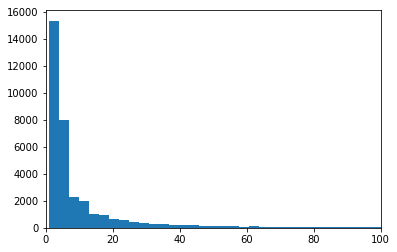

In [39]:
plt.hist(list(clean_dict.values()), bins = 100)
plt.xlim(0, 100)

In [48]:
tokens[0]

'can you please explain what materialism and atheism did to tibet, china or cambodia?'

In [49]:
tokens = nltk.sent_tokenize(raw_text)
lens = [len(s.split(' ')) for s in tokens]

(array([  1.64787000e+05,   3.39600000e+03,   7.00000000e+01,
          1.20000000e+01,   8.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   33.3,   65.6,   97.9,  130.2,  162.5,  194.8,  227.1,
         259.4,  291.7,  324. ]),
 <a list of 10 Patch objects>)

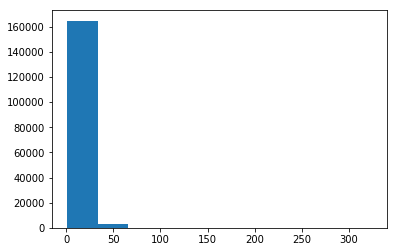

In [51]:
plt.hist(lens)

### Removing Links
1. The format for links is "[link description] (link.link)"

In [ ]:
def contains_link(dictionary):
    """ Determines if the comment contains a link.
    Returns a list of Booleans indicating this.
    """
    return {key: value for key, value in dictionary.items() 
           if fnmatch.fnmatch(value, "*[ * ]*") }

In [ ]:
sample = "This is a test[at](ata)"
import re
import fnmatch

In [ ]:
link_dict = contains_link(values_dict)

In [ ]:
values_dict